In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageEnhance
from skimage import img_as_float
from skimage.transform import rotate
from skimage.filters import unsharp_mask
from skimage.io import imsave
import imageio


Jumlah data:
labels
happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
disgust      436
Name: count, dtype: int64


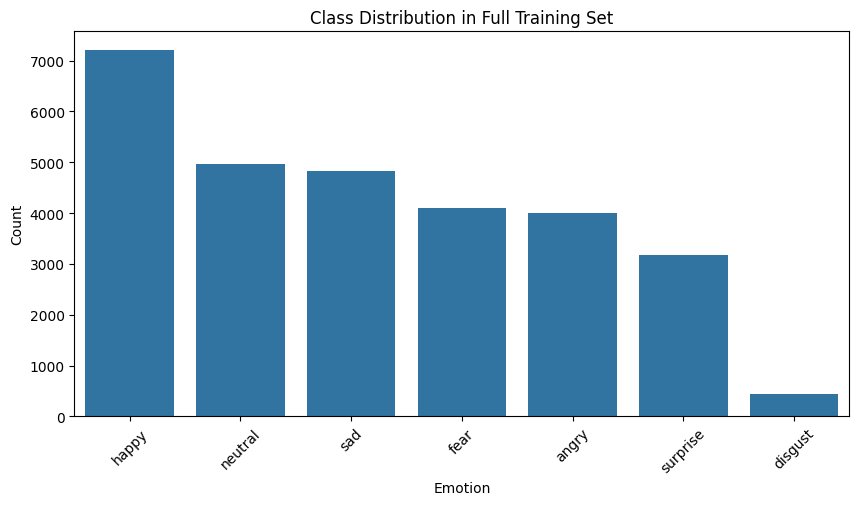

In [3]:
train_dir = 'C:/JESIKA/.vscode/.vscode SEMESTER 4/Pengolahan Citra Digital/DATASET WAJAH/train'
train_filepaths = []
train_labels = []


folds = os.listdir(train_dir)
for fold in folds:
    fold_path = os.path.join(train_dir, fold)
    filelist = os.listdir(fold_path)
    for file in filelist:
        fpath = os.path.join(fold_path, file)
        train_filepaths.append(fpath)
        train_labels.append(fold)


Fseries = pd.Series(train_filepaths, name='filepaths')
Lseries = pd.Series(train_labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis=1)

print("Jumlah data:")
print(train_df['labels'].value_counts())

plt.figure(figsize=(10, 5))
sns.countplot(data=train_df, x='labels', order=train_df['labels'].value_counts().index)
plt.title('Class Distribution in Full Training Set')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


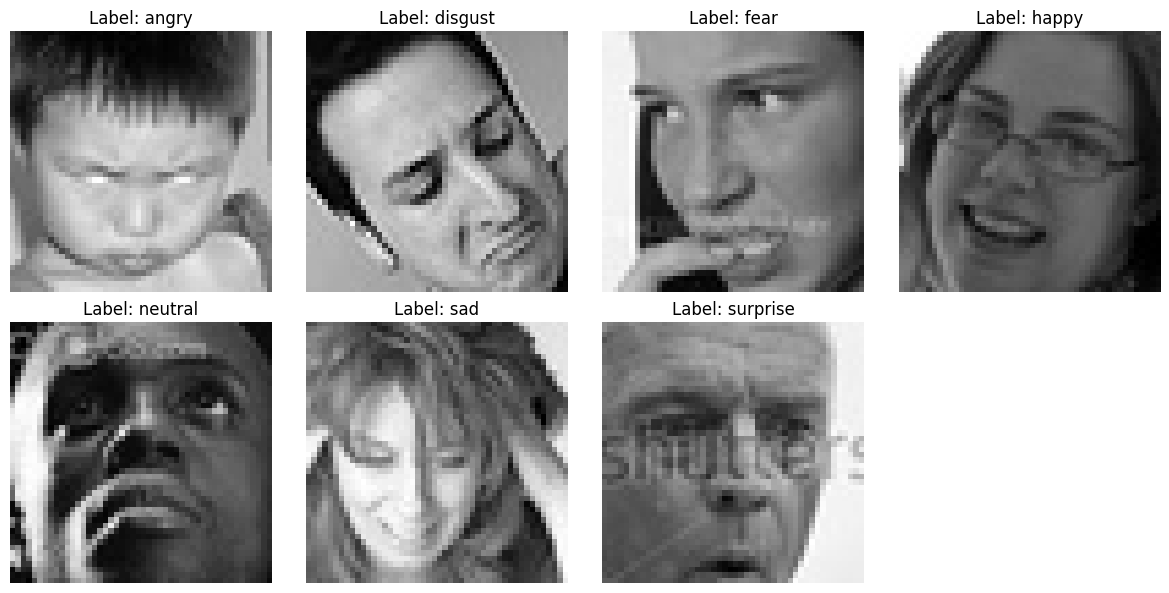

In [4]:
emotion_labels = train_df['labels'].unique()
fig = plt.figure(figsize=(12, 6))


for i, label in enumerate(emotion_labels):
    sample = train_df[train_df['labels'] == label].iloc[0]
    img_path = sample['filepaths']
    img_arr = Image.open(img_path)

    ax = fig.add_subplot(2, (len(emotion_labels) + 1) // 2, i + 1)
    ax.imshow(img_arr, cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()


# Pre-Processing

>Cek Size

In [5]:
all_images = train_df['filepaths'].tolist()
all_sizes = [Image.open(img).size for img in all_images]
heights = [img_shape[1] for img_shape in all_sizes]
widths = [img_shape[0] for img_shape in all_sizes]

print(f"Minimum image height: {min(heights)}")
print(f"Maximum image height: {max(heights)}")
print()
print(f"Minimum image width: {min(widths)}")
print(f"Maximum image width: {max(widths)}")

Minimum image height: 48
Maximum image height: 48

Minimum image width: 48
Maximum image width: 48


> Resize

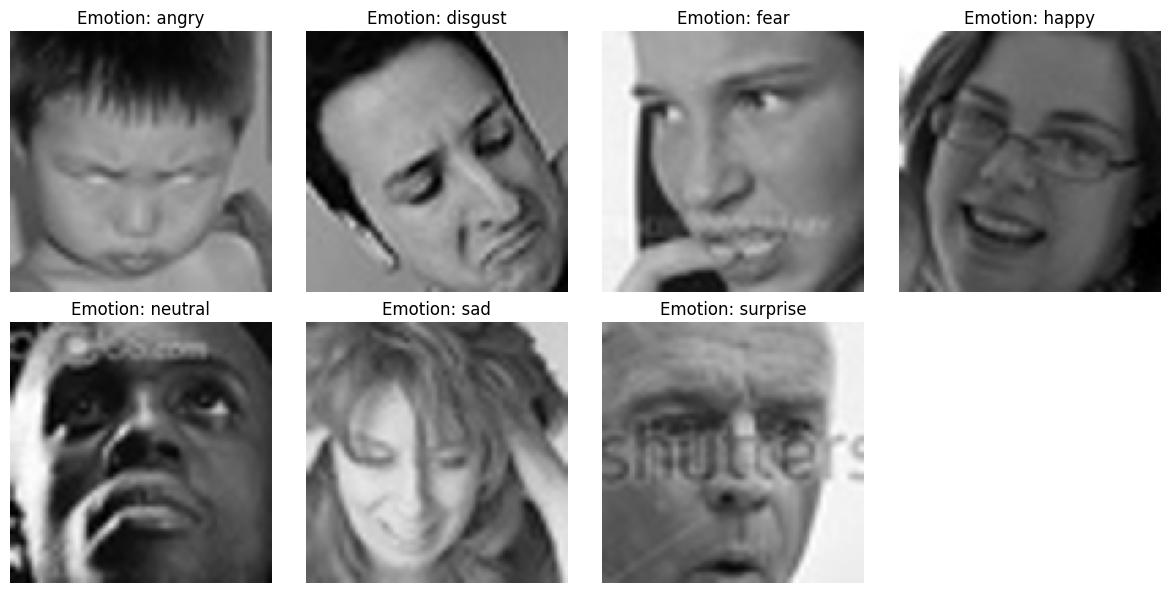

In [6]:
emotion_labels = train_df['labels'].unique()
all_images_resized = []
for img_path in all_images:
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')

    resized_img = img.resize((96, 96))
    label = train_df[train_df['filepaths'] == img_path]['labels'].iloc[0]
    all_images_resized.append((resized_img, label))

fig = plt.figure(figsize=(12, 6))

for i, label in enumerate(emotion_labels):
    sample_img = next(img for img, lbl in all_images_resized if lbl == label)

    ax = fig.add_subplot(2, (len(emotion_labels) + 1) // 2, i + 1)
    ax.imshow(sample_img)
    ax.set_title(f"Emotion: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()


> Normalisasi

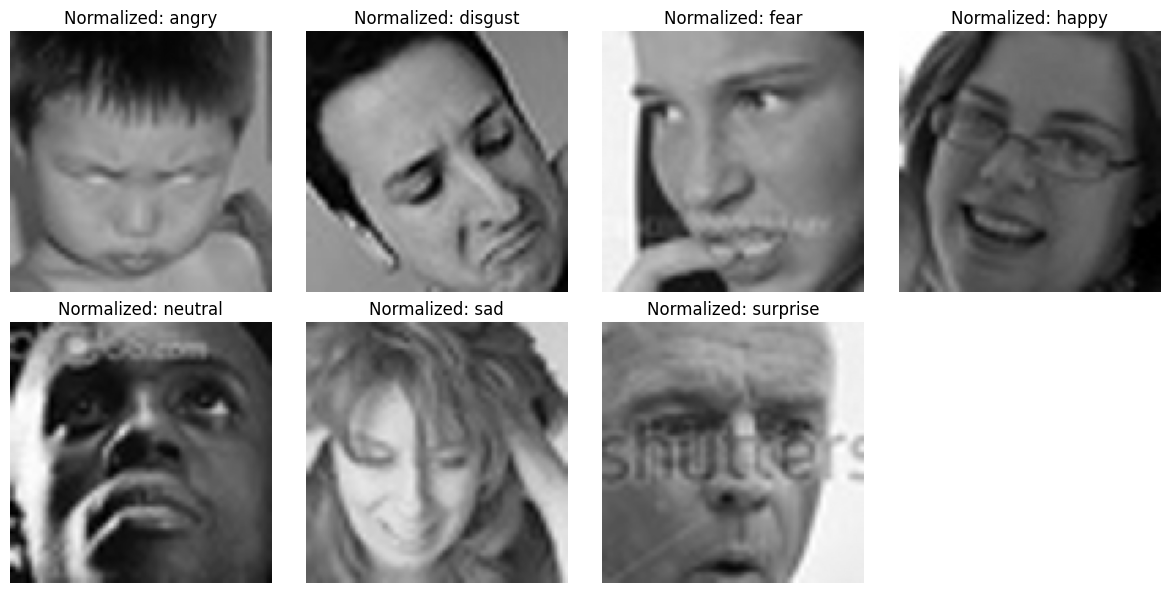

In [7]:
import numpy as np
import matplotlib.pyplot as plt

n_images = len(all_images_resized)
sum_img = np.zeros((96, 96, 3), dtype=np.float64)
sum_sq_img = np.zeros((96, 96, 3), dtype=np.float64)

for img, _ in all_images_resized:
    img_arr = np.array(img, dtype=np.float32) / 255.0
    sum_img += img_arr
    sum_sq_img += img_arr ** 2

mean = sum_img / n_images
std = np.sqrt(sum_sq_img / n_images - mean ** 2)
std[std == 0] = 1.0  # untuk menghindari pembagian dengan nol
mean32 = mean.astype(np.float32)
std32 = std.astype(np.float32)


normalized_images_resized = []
for img, label in all_images_resized:
    img_arr = np.array(img, dtype=np.float32) / 255.0
    normalized_img = (img_arr - mean32) / std32
    normalized_images_resized.append((normalized_img, label))


fig = plt.figure(figsize=(12, 6))
for i, label in enumerate(emotion_labels):
    sample_img = next(img for img, lbl in normalized_images_resized if lbl == label)
    ax = fig.add_subplot(2, (len(emotion_labels) + 1) // 2, i + 1)
    ax.imshow(np.clip(sample_img * std + mean, 0, 1))
    ax.set_title(f"Normalized: {label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

>Augmentasi

In [ ]:
import os
import numpy as np
import imageio
from skimage.transform import rotate, rescale
from skimage.util import random_noise
from skimage.filters import unsharp_mask

base_save_path = "C:/JESIKA/.vscode/.vscode SEMESTER 4/Pengolahan/augmented_full"

def apply_top5_augmentations(img, mean, std):
    img_original = img * std + mean
    augmentations = []

    augmentations.append(("rot15", rotate(img_original, angle=15, mode='edge')))
    augmentations.append(("flip_h", np.fliplr(img_original)))
    augmentations.append(("bright_up", np.clip(img_original + 0.2, 0, 1)))
    augmentations.append(("bright_down", np.clip(img_original - 0.2, 0, 1)))
    augmentations.append(("gauss_noise", random_noise(img_original, mode='gaussian', var=0.01)))

    augmentations.append(("rot-15", rotate(img_original, angle=-15, mode='edge')))
    augmentations.append(("flip_v", np.flipud(img_original)))
    augmentations.append(("crop_center", img_original[5:-5, 5:-5]))  # crop tengah (jika gambar cukup besar)
    augmentations.append(("sharpen", unsharp_mask(img_original, radius=1, amount=1)))
    augmentations.append(("scale90", rescale(img_original, 0.9, mode='reflect', anti_aliasing=True)))  # skala 90%

    return img_original, augmentations  # return juga gambar asli

for i, (img_norm, label) in enumerate(normalized_images_resized):
    img_original, augmented_list = apply_top5_augmentations(img_norm, mean, std)

    label_folder = os.path.join(base_save_path, str(label))
    os.makedirs(label_folder, exist_ok=True)

    # gambar asli
    img_original_uint8 = (np.clip(img_original, 0, 1) * 255).astype(np.uint8)
    original_path = os.path.join(label_folder, f"{label}_{i}_original.png")
    imageio.imwrite(original_path, img_original_uint8)

    # hasil augmentasi
    for aug_name, aug_img in augmented_list:
        aug_img = np.clip(aug_img, 0, 1)
        if aug_img.ndim == 2:
            aug_img = np.expand_dims(aug_img, axis=-1)
        aug_uint8 = (aug_img * 255).astype(np.uint8)
        save_path = os.path.join(label_folder, f"{label}_{i}_{aug_name}.png")
        imageio.imwrite(save_path, aug_uint8)


> Cek dataset setelah Augmentasi

Jumlah data per kelas:
labels
happy       79365
neutral     54615
sad         53130
fear        45067
angry       43945
surprise    34881
disgust      4796
Name: count, dtype: int64


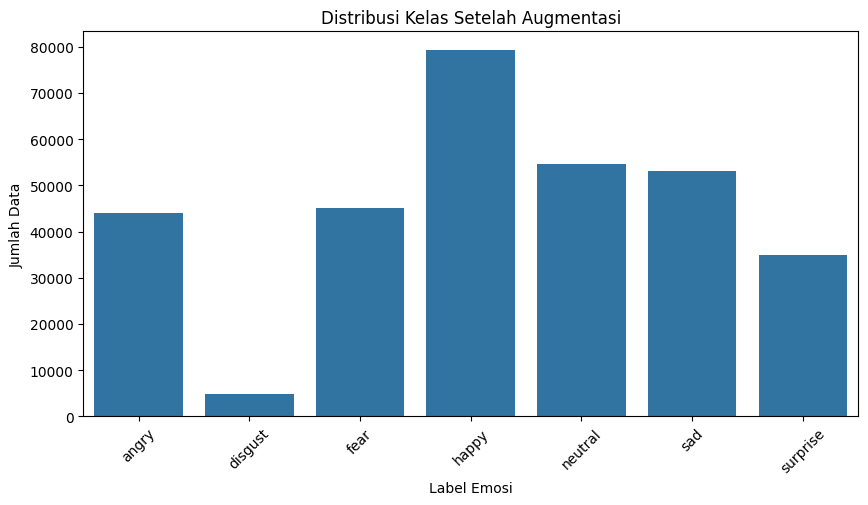

In [10]:
augmented_dir = "C:/JESIKA/.vscode/.vscode SEMESTER 4/Pengolahan/augmented_full"

augmented_labels = []

for label in os.listdir(augmented_dir):
    label_folder = os.path.join(augmented_dir, label)
    if os.path.isdir(label_folder):
        augmented_labels.extend([label] * len(os.listdir(label_folder)))

augmented_df = pd.DataFrame({'labels': augmented_labels})

print("Jumlah data per kelas:")
print(augmented_df['labels'].value_counts())

plt.figure(figsize=(10, 5))
sns.countplot(data=augmented_df, x='labels')
plt.title('Distribusi Kelas Setelah Augmentasi')
plt.xlabel('Label Emosi')
plt.ylabel('Jumlah Data')
plt.xticks(rotation=45)
plt.show()

# Face Detection

In [11]:
import cv2

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [12]:
import os

input_dir = augmented_dir
output_dir = "C:/JESIKA/.vscode/.vscode SEMESTER 4/Pengolahan/full"
os.makedirs(output_dir, exist_ok=True)

for label in os.listdir(input_dir):
    label_path = os.path.join(input_dir, label)
    if not os.path.isdir(label_path):
        continue

    output_label_path = os.path.join(output_dir, label)
    os.makedirs(output_label_path, exist_ok=True)

    for img_name in os.listdir(label_path):
        img_path = os.path.join(label_path, img_name)

        # gambar grayscale
        gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        img = cv2.imread(img_path)

        for i, (x, y, w, h) in enumerate(faces):
            face_img = img[y:y+h, x:x+w]
            face_save_path = os.path.join(output_label_path, f"{os.path.splitext(img_name)[0]}_face{i}.jpg")
            cv2.imwrite(face_save_path, face_img)

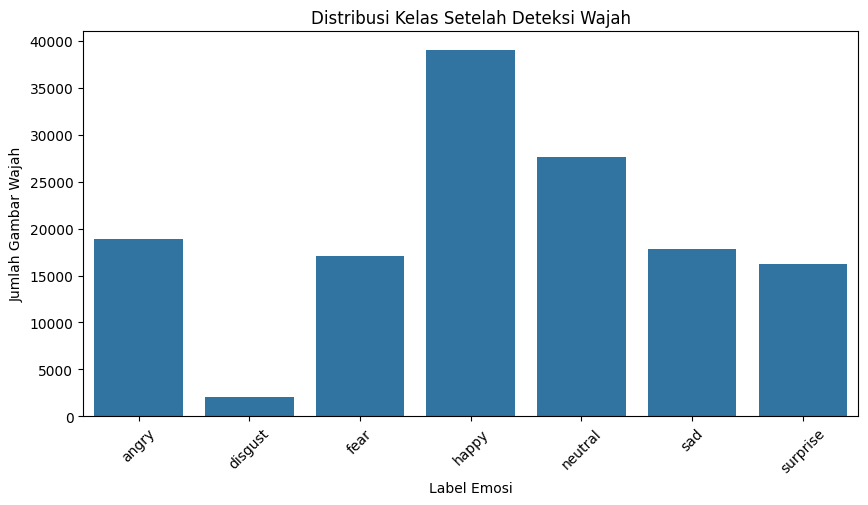

In [13]:
detected_labels = []

for label in os.listdir(output_dir):
    label_folder = os.path.join(output_dir, label)
    if os.path.isdir(label_folder):
        detected_labels.extend([label] * len(os.listdir(label_folder)))

detected_df = pd.DataFrame({'labels': detected_labels})

plt.figure(figsize=(10, 5))
sns.countplot(data=detected_df, x='labels')
plt.title('Distribusi Kelas Setelah Deteksi Wajah')
plt.xlabel('Label Emosi')
plt.ylabel('Jumlah Gambar Wajah')
plt.xticks(rotation=45)
plt.show()

In [15]:
!pip install scikit-learn


  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.1 MB 508.0 kB/s eta 0:00:21
   - -------------------------------------- 0.5/11.1 MB 508.0 kB/s eta 0:00:21
   - -------------------------------------- 0.5/11.1 MB 508.0 kB/s eta 0:00:21
   -- ------------------------------------- 0.8/11.1 MB 486.4 kB/s eta 0:00:22
   --- ------------------------------------ 1.0/11.1 MB 546.9 kB/s eta 0:00:19
   --- ------------------------------------ 1.

# Random Forest

In [ ]:
import cv2
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import hog

dataset_dir = "C:/JESIKA/.vscode/.vscode SEMESTER 4/Pengolahan/full"

features = []
labels = []

# ekstraksi fitur menggunakan HOG
for label in os.listdir(dataset_dir):
    label_path = os.path.join(dataset_dir, label)
    if not os.path.isdir(label_path):
        continue
    
    for img_name in os.listdir(label_path):
        img_path = os.path.join(label_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (96, 96))  # standardisasi ukuran
        hog_features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), block_norm='L2-Hys')
        features.append(hog_features)
        labels.append(label)

X = np.array(features)
y = np.array(labels)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

y_pred = clf.predict(X)
print("Accuracy (evaluasi pada data latih):", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))


Accuracy (evaluasi pada data latih): 0.9988256653362344
Classification Report:
               precision    recall  f1-score   support

       angry       1.00      1.00      1.00     18887
     disgust       1.00      1.00      1.00      2113
        fear       1.00      1.00      1.00     17123
       happy       1.00      1.00      1.00     39039
     neutral       1.00      1.00      1.00     27604
         sad       1.00      1.00      1.00     17783
    surprise       1.00      1.00      1.00     16253

    accuracy                           1.00    138802
   macro avg       1.00      1.00      1.00    138802
weighted avg       1.00      1.00      1.00    138802



In [ ]:
import joblib

model_path = "C:/JESIKA/.vscode/.vscode SEMESTER 4/Pengolahan/1111.random_forest_model.pkl"
joblib.dump(clf, model_path)

print(f"Model disimpan di: {model_path}")


Model disimpan di: C:/JESIKA/.vscode/.vscode SEMESTER 4/Pengolahan/1111.random_forest_model.pkl


In [ ]:
import os
import numpy as np
import joblib
import cv2
from sklearn.metrics import accuracy_score
from skimage.feature import hog

# model
rf = joblib.load("C:/JESIKA/.vscode/.vscode SEMESTER 4/Pengolahan/1111.random_forest_model.pkl")

# data uji
data_dir = "C:/JESIKA/.vscode/.vscode SEMESTER 4/PCD/data_testtt"

image_data = []
true_labels = []
filenames = []

all_labels = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
label_to_int = {label: idx for idx, label in enumerate(sorted(all_labels))}
int_to_label = {v: k for k, v in label_to_int.items()}
print("Mapping label ke angka:", label_to_int)

for label in all_labels:
    label_folder = os.path.join(data_dir, label)
    for filename in os.listdir(label_folder):
        if filename.endswith(".png"):
            img_path = os.path.join(label_folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img_resized = cv2.resize(img, (96, 96))  # sesuai dengan model
            hog_features = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                               cells_per_block=(2, 2), block_norm='L2-Hys')
            image_data.append(hog_features)
            # true_labels.append(label_to_int[label])
            true_labels.append(label)

            filenames.append(f"{label}/{filename}")

X_test_array = np.array(image_data)
predictions = rf.predict(X_test_array)

for fname, pred in zip(filenames, predictions):
    print(f"{fname} -> Prediksi Emosi: {pred}")


accuracy = accuracy_score(true_labels, predictions)
print(f"Akurasi prediksi: {accuracy * 100:.2f}%")


Mapping label ke angka: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
angry/face_0_0.png -> Prediksi Emosi: happy
angry/face_102_0.png -> Prediksi Emosi: angry
angry/face_103_0.png -> Prediksi Emosi: angry
angry/face_104_0.png -> Prediksi Emosi: neutral
angry/face_105_0.png -> Prediksi Emosi: neutral
angry/face_106_0.png -> Prediksi Emosi: happy
angry/face_107_0.png -> Prediksi Emosi: neutral
angry/face_108_0.png -> Prediksi Emosi: fear
angry/face_111_0.png -> Prediksi Emosi: happy
angry/face_114_0.png -> Prediksi Emosi: neutral
angry/face_115_0.png -> Prediksi Emosi: angry
angry/face_117_0.png -> Prediksi Emosi: angry
angry/face_11_0.png -> Prediksi Emosi: neutral
angry/face_120_0.png -> Prediksi Emosi: angry
angry/face_121_0.png -> Prediksi Emosi: sad
angry/face_122_0.png -> Prediksi Emosi: angry
angry/face_125_0.png -> Prediksi Emosi: happy
angry/face_127_0.png -> Prediksi Emosi: angry
angry/face_128_0.png -> Prediksi Emosi: angry
angry/fac

In [20]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions))


              precision    recall  f1-score   support

       angry       0.56      0.33      0.41       510
     disgust       1.00      0.37      0.54        65
        fear       0.64      0.29      0.40       490
       happy       0.60      0.91      0.72      1074
     neutral       0.43      0.66      0.52       755
         sad       0.51      0.16      0.25       512
    surprise       0.80      0.66      0.72       478

    accuracy                           0.57      3884
   macro avg       0.65      0.48      0.51      3884
weighted avg       0.59      0.57      0.54      3884



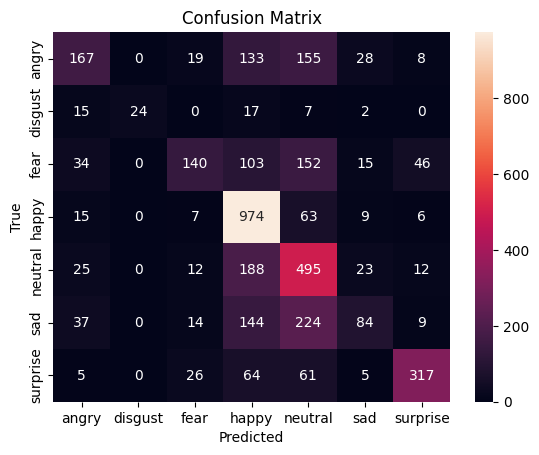

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions, labels=clf.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import numpy as np

# hitung total benar dan salah
correct_per_class = np.diag(cm)  # elemen diagonal = prediksi benar per kelas
total_per_class = np.sum(cm, axis=1)  # total data asli per kelas
incorrect_per_class = total_per_class - correct_per_class

print("Distribusi Prediksi Benar dan Salah per Kelas:")
for i, label in enumerate(clf.classes_):
    print(f"Label: {label}")
    print(f"  Benar   : {correct_per_class[i]}")
    print(f"  Salah   : {incorrect_per_class[i]}")
    print(f"  Total   : {total_per_class[i]}")
    print("-" * 30)

total_correct = np.sum(correct_per_class)
total_samples = np.sum(cm)
print(f"\nTotal Benar: {total_correct}")
print(f"Total Salah: {total_samples - total_correct}")
print(f"Akurasi: {total_correct / total_samples:.2%}")


Distribusi Prediksi Benar dan Salah per Kelas:
Label: angry
  Benar   : 167
  Salah   : 343
  Total   : 510
------------------------------
Label: disgust
  Benar   : 24
  Salah   : 41
  Total   : 65
------------------------------
Label: fear
  Benar   : 140
  Salah   : 350
  Total   : 490
------------------------------
Label: happy
  Benar   : 974
  Salah   : 100
  Total   : 1074
------------------------------
Label: neutral
  Benar   : 495
  Salah   : 260
  Total   : 755
------------------------------
Label: sad
  Benar   : 84
  Salah   : 428
  Total   : 512
------------------------------
Label: surprise
  Benar   : 317
  Salah   : 161
  Total   : 478
------------------------------

Total Benar: 2201
Total Salah: 1683
Akurasi: 56.67%
